In [1]:
import pandas as pd

oct_merged = pd.read_csv('../DATASET/obs_est_merged/oct_merged.csv')

C:\Users\DataScience\AppData\Local\Temp\ipykernel_3304\2923882287.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
oct_merged

,lat,lon,year,month,precip_est,precip_obs,bias_oct
0,45.0,-20.0,1981,11,136.470150,150.665280,-14.195130
1,45.0,-19.0,1981,11,132.524840,139.511110,-6.986270
2,45.0,-18.0,1981,11,128.341250,122.909546,5.431704
3,45.0,-17.0,1981,11,122.454530,117.767334,4.687196
4,45.0,-16.0,1981,11,120.415470,122.222900,-1.807430
...,...,...,...,...,...,...,...
230251,20.0,16.0,2017,4,0.039531,0.114441,-0.074910
230252,20.0,17.0,2017,4,0.039531,0.000000,0.039531
230253,20.0,18.0,2017,4,0.074687,0.057220,0.017467
230254,20.0,19.0,2017,4,0.082500,0.171661,-0.089162


In [3]:
oct_merged = oct_merged.drop(columns=['year', 'bias_oct'])

In [4]:
oct_average= oct_merged.groupby(['month', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
oct_average['is_train'] = oct_average['month'].apply(lambda x: x in [11, 12, 1])  # temporary splitting

In [5]:
oct_average

,month,lat,lon,precip_est,precip_obs,is_train
0,1,20.0,-20.0,3.457527,2.457407,True
1,1,20.0,-19.0,2.821785,2.952894,True
2,1,20.0,-18.0,2.248868,2.349642,True
3,1,20.0,-17.0,2.007007,2.645599,True
4,1,20.0,-16.0,2.073196,3.575113,True
...,...,...,...,...,...,...
6391,12,45.0,16.0,105.600369,79.106119,True
6392,12,45.0,17.0,89.607421,67.010138,True
6393,12,45.0,18.0,70.682726,58.495204,True
6394,12,45.0,19.0,63.572699,50.671153,True


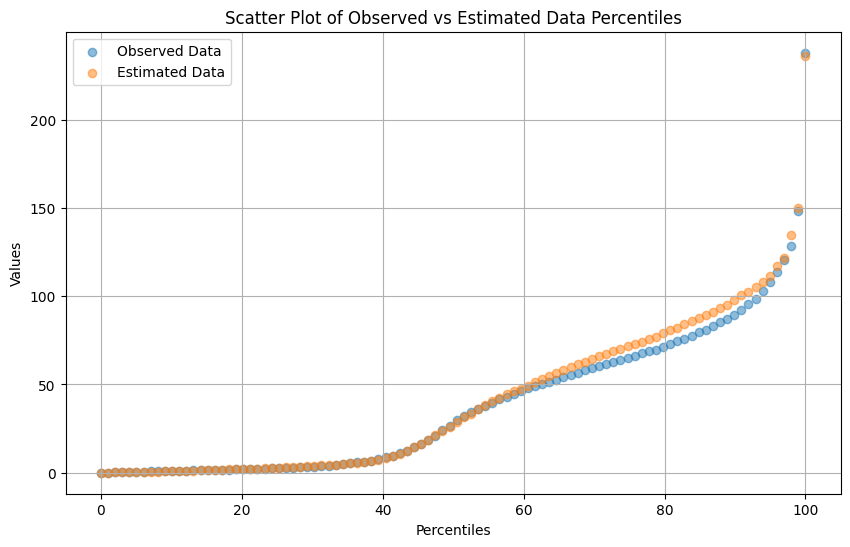

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = oct_average[oct_average['is_train'] == True]['precip_obs']  # ref_data_ast
estimated_data = oct_average[oct_average['is_train'] == True]['precip_est']  # estimated_past

# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Estimated Data')

plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an over estimation generally!!

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future, hyper):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        percentile = percentileofscore(model_present_safe, model_value)
        percentile_ref = np.percentile(ref_dataset, percentile)
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        model_future_corrected[ival] = model_future_safe[ival] * (1 + hyper * dif)
            
    return model_present_corrected, model_future_corrected

In [8]:
# Applying the correction
oct_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = oct_average['is_train']
ref_dataset = oct_average[is_train]['precip_obs']
model_present = oct_average[is_train]['precip_est']
model_future = oct_average[~is_train]['precip_est']

best_rmse = np.inf  # Initialize the best RMSE with a very large number
best_hyper = None 

for hyper in np.arange(0, 3.1, 0.1):  # Loop from 0 to 3 with a step of 0.1
    model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future, hyper)

    # Correct the DataFrame
    oct_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
    oct_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

    test_data = oct_average[~is_train]  # Simpler way to filter out test data
    rmse = np.sqrt(np.mean((test_data['corrected_precip_est'] - test_data['precip_obs'])**2))

    if rmse < best_rmse:
        best_rmse = rmse
        best_hyper = hyper

    # Print RMSE for each iteration (optional)
    print(f"Hyperparameter: {hyper:.1f}, RMSE: {rmse}")

# After all iterations, print the best RMSE found
print(f"Best Hyperparameter: {best_hyper:.1f}, Best RMSE: {best_rmse}")

C:\Users\DataScience\AppData\Local\Temp\ipykernel_3304\1653739444.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.03468391  2.55299411  2.15501189 ... 64.00972817 58.67818487
 51.95927378]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oct_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


Hyperparameter: 0.0, RMSE: 18.604256065700646
Hyperparameter: 0.1, RMSE: 18.40618366661013
Hyperparameter: 0.2, RMSE: 18.212435369172514
Hyperparameter: 0.3, RMSE: 18.02315062579406
Hyperparameter: 0.4, RMSE: 17.838471525899017
Hyperparameter: 0.5, RMSE: 17.658542572280236
Hyperparameter: 0.6, RMSE: 17.483510421829802
Hyperparameter: 0.7, RMSE: 17.313523588799118
Hyperparameter: 0.8, RMSE: 17.148732108994242
Hyperparameter: 0.9, RMSE: 16.989287163641414
Hyperparameter: 1.0, RMSE: 16.83534066206461
Hyperparameter: 1.1, RMSE: 16.687044782804882
Hyperparameter: 1.2, RMSE: 16.54455147338179
Hyperparameter: 1.3, RMSE: 16.408011909548875
Hyperparameter: 1.4, RMSE: 16.27757591562363
Hyperparameter: 1.5, RMSE: 16.153391348269793
Hyperparameter: 1.6, RMSE: 16.035603446964465
Hyperparameter: 1.7, RMSE: 15.924354155277827
Hyperparameter: 1.8, RMSE: 15.819781418009674
Hyperparameter: 1.9, RMSE: 15.72201846013954
Hyperparameter: 2.0, RMSE: 15.631193054428286
Hyperparameter: 2.1, RMSE: 15.5474267853

In [9]:
# Applying the correction
oct_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = oct_average['is_train']
ref_dataset = oct_average[is_train]['precip_obs']
model_present = oct_average[is_train]['precip_est']
model_future = oct_average[~is_train]['precip_est']

model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future, 3)

# Correct the DataFrame
oct_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
oct_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

test_data = oct_average[oct_average['is_train'] == False]
oct_average.loc[test_data.index, 'RMSE'] = np.sqrt((test_data['corrected_precip_est'] - test_data['precip_obs'])**2)

# mean_squared_error = oct_average['RMSE'].mean()

# Step 3: Calculate the Global RMSE
global_rmse = np.sqrt(np.mean((test_data['corrected_precip_est'] - test_data['precip_obs'])**2))

print("Global RMSE:", global_rmse)

Global RMSE: 15.127288159127604


C:\Users\DataScience\AppData\Local\Temp\ipykernel_3304\2338209367.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.03468391  2.55299411  2.15501189 ... 64.00972817 58.67818487
 51.95927378]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  oct_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


In [10]:
oct_average.dtypes

month                     int64
lat                     float64
lon                     float64
precip_est              float64
precip_obs              float64
is_train                   bool
corrected_precip_est    float64
RMSE                    float64
dtype: object

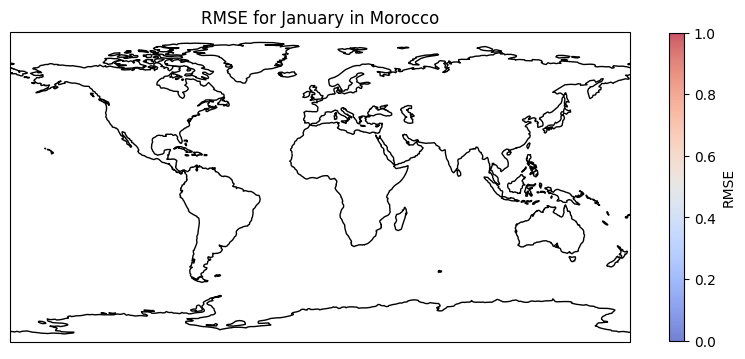

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

# Load your data into a DataFrame.
df = oct_average

# Filter the DataFrame for January and is_train == False.
january_test_df = df[df['month'] == 5]

# Create a scatter plot using plt.scatter for the lat/lon with the color intensity based on the RMSE.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# You might want to adjust the extent to frame Morocco properly
# ax.set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', 
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

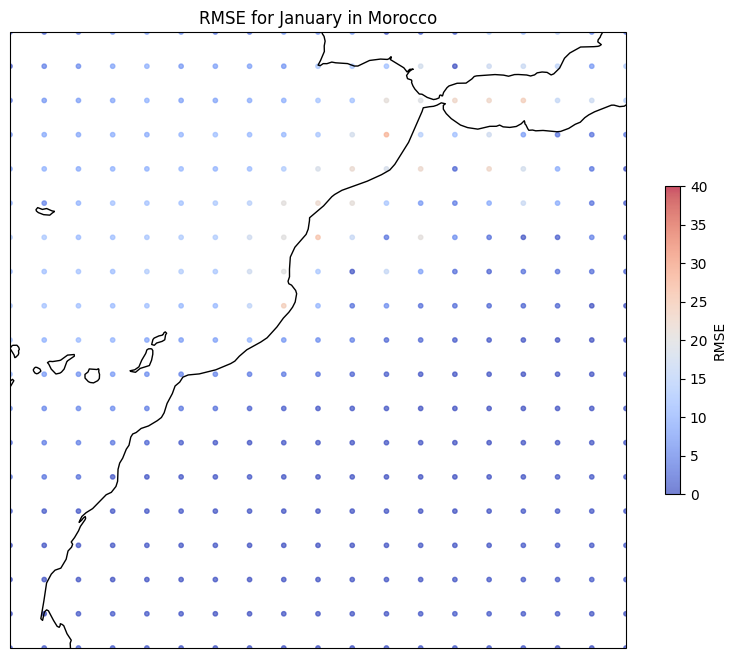

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load your data into a DataFrame.
df = oct_average  # Make sure 'oct_average' is defined and contains your data.

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 4) & (df['is_train'] == False)]

# Start by setting up the figure and axes with the desired size and projection.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to frame Morocco properly.
# This should come before plotting the scatter plot to avoid any overlay issues.
ax.set_extent([-18, 0, 20, 38])

# Add the coastlines to the map for reference.
ax.coastlines()

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', vmin=0, vmax=40,
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

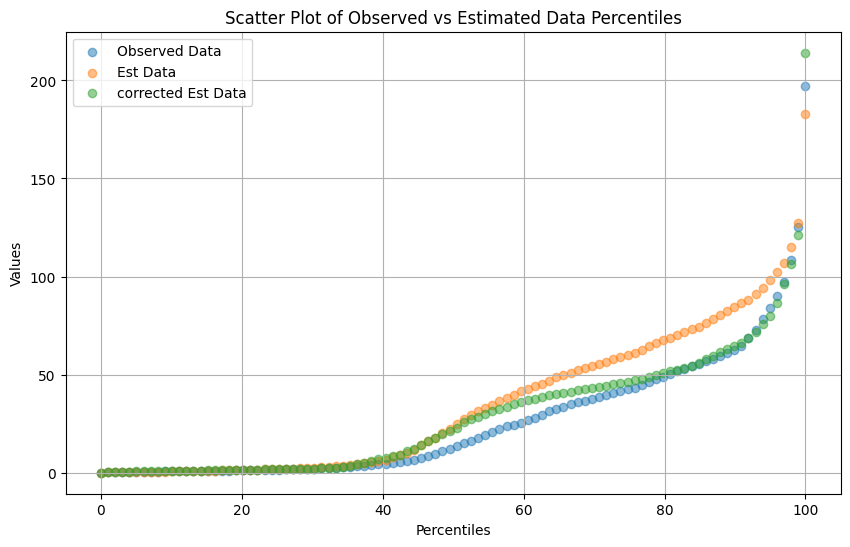

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = oct_average[oct_average['is_train'] == False]['precip_obs']
estimated_data = oct_average[oct_average['is_train'] == False]['precip_est']
corrected_estimated_data = oct_average[oct_average['is_train'] == False]['corrected_precip_est']


# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)
corrected_estimated_percentiles = np.percentile(corrected_estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Est Data')
plt.scatter(percentiles, corrected_estimated_percentiles, alpha=0.5, label='corrected Est Data')


plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an under isitimation generally!!

In [14]:
oct_average

,month,lat,lon,precip_est,precip_obs,is_train,corrected_precip_est,RMSE
0,1,20.0,-20.0,3.457527,2.457407,True,3.034684,NaN
1,1,20.0,-19.0,2.821785,2.952894,True,2.552994,NaN
2,1,20.0,-18.0,2.248868,2.349642,True,2.155012,NaN
3,1,20.0,-17.0,2.007007,2.645599,True,1.902917,NaN
4,1,20.0,-16.0,2.073196,3.575113,True,1.971375,NaN
...,...,...,...,...,...,...,...,...
6391,12,45.0,16.0,105.600369,79.106119,True,99.100460,NaN
6392,12,45.0,17.0,89.607421,67.010138,True,81.070240,NaN
6393,12,45.0,18.0,70.682726,58.495204,True,64.009728,NaN
6394,12,45.0,19.0,63.572699,50.671153,True,58.678185,NaN


In [15]:
oct_avecoef_rmse = oct_average[oct_average['is_train'] == False].groupby('month')['RMSE'].mean()

oct_avecoef_rmse.to_csv('../DATASET/for_heatmap/oct_avecoef_rmse.csv', header=True)

## Test on 2023

In [16]:
oct_sub = pd.read_csv ('../DATASET/dataset_test2023/oct23.csv')

oct_sub

,time,lat,lon,prec_est,year,month
0,2023-11-01,40.0,-20.0,3.769799,2023,11
1,2023-11-01,40.0,-19.0,3.541406,2023,11
2,2023-11-01,40.0,-18.0,3.285058,2023,11
3,2023-11-01,40.0,-17.0,2.942162,2023,11
4,2023-11-01,40.0,-16.0,2.566186,2023,11
...,...,...,...,...,...,...
5161,2024-04-01,20.0,16.0,0.003465,2024,4
5162,2024-04-01,20.0,17.0,0.003465,2024,4
5163,2024-04-01,20.0,18.0,0.004136,2024,4
5164,2024-04-01,20.0,19.0,0.004442,2024,4


In [19]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future, coef):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        # Calculate the percentile score for the model value
        percentile = percentileofscore(model_present_safe, model_value)
        # Clamp the percentile value to be between 0 and 100
        percentile = max(0, min(100, percentile))
        # Calculate the reference percentile value
        percentile_ref = np.percentile(ref_dataset, percentile)
        # Calculate the difference and adjust model_present
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        # Apply the same adjustment to model_future
        model_future_corrected[ival] = model_future_safe[ival] * (1 + coef * dif)
            
    return model_present_corrected, model_future_corrected

In [20]:
ref_dataset_sub = oct_average[(oct_average['lat'] <= 40)]['precip_obs']
model_present_sub = oct_average[(oct_average['lat'] <= 40)]['precip_est']
model_future_sub = oct_sub['prec_est']

_, model_future_corrected_sub = eQM_porcentual_delta(ref_dataset_sub, model_present_sub, model_future_sub, 3)

# print(len(ref_dataset_sub), len(model_present_sub), len(model_future_sub))

In [21]:
submission_oct_df = pd.DataFrame({ # Example: creating a sequence of IDs from 1 to 781
    'lat': oct_sub['lat'],
    'lon': oct_sub['lon'],
    'month': oct_sub['month'],
    'prec_est': oct_sub['prec_est'],
    'corrected_prec': model_future_corrected_sub,
})

In [22]:
submission_oct_df

,lat,lon,month,prec_est,corrected_prec
0,40.0,-20.0,11,3.769799,1.999322
1,40.0,-19.0,11,3.541406,2.181888
2,40.0,-18.0,11,3.285058,2.299181
3,40.0,-17.0,11,2.942162,2.133335
4,40.0,-16.0,11,2.566186,1.904712
...,...,...,...,...,...
5161,20.0,16.0,4,0.003465,0.004038
5162,20.0,17.0,4,0.003465,0.002646
5163,20.0,18.0,4,0.004136,0.005331
5164,20.0,19.0,4,0.004442,0.004265


In [23]:
submission_oct_df.to_csv('../DATASET/submission/submission_oct.csv')